# El problema

Una empresa de bicicletas compartidas que opera en el área de una ciudad específica. tiene un esquema de funcionamiento en el cual los usuarios pueden alquilar una bicicleta desde un lugar en particular y devolverla en un luar diferente utilizando su infraestructura.

El problema consiste en predecir cuántas bicicletas se van a utilizar en el futuro. Para ello se nos facilita un archivo  [csv](https://drive.google.com/open?id=1gTcb3WZ27DU0nMdvoyPBMYRFK8LU8-rt) donde aparecen el número de bicicletas contratadas todos los días y las variables metereológicas de esos días.

Se usará análisis de regresión con el fin de capturar la relación entre características y número de bicicletas contratadas en un modelo.


También veremos cómo se obtiene el fichero excel con los resultados, que posteriormente se podría subir a las webs de competiciones.

# 0. Carga de Datos

Cargaremos los datos de la misma forma que lo hemos hecho otras veces en Google Collaboratory.


In [28]:
# 0. load data from file
from google.colab import files
import seaborn as sns

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving bikes.csv to bikes (1).csv
User uploaded file "bikes.csv" with length 54187 bytes


Posteriomente lo cargamos en un DataFrame de Pandas con el nombre de *bikes*

In [29]:
# 0. load data in DataFrame
import pandas as pd
import io
bikes = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), 
                    index_col = 'date')
bikes.head()

,temperature,humidity,windspeed,count
date,,,,
2011-01-03,2.716070,45.715346,21.414957,120.0
2011-01-04,2.896673,54.267219,15.136882,108.0
2011-01-05,4.235654,45.697702,17.034578,82.0
2011-01-06,3.112643,50.237349,10.091568,88.0
2011-01-07,2.723918,49.144928,15.738204,148.0


Vamos a dividir nuestro conjunto de datos en dos partes una para entrenamiento (tuning/train) y otra para test. Para ello vamos a utilizar los datos de 2011 y la mitad de 2012 para entrenamiento y el resto de 2012 para los tests.  

In [30]:
# Importante la función .to_html y display_html -> Muestra el contenido de un dataframe en formato HTML
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [31]:
# 0.1 features and labels
df = bikes[['temperature', 'humidity', 'windspeed', 'count']]

train = df.loc['2011-01-01':'2011-12-31']
test  = df.loc['2012-01-01':]

display_side_by_side(train.tail(),test.head())

,temperature,humidity,windspeed,count
date,,,,
2011-12-27,9.105544,63.874550,17.145141,103.0
2011-12-28,7.820556,49.436222,24.671369,255.0
2011-12-29,5.297420,53.358888,12.220576,254.0
2011-12-30,8.443281,56.848605,13.285195,491.0
2011-12-31,6.435742,54.120804,17.410529,390.5
,temperature,humidity,windspeed,count
date,,,,
2012-01-01,4.428203,51.393004,21.535863,290.0
2012-01-02,2.420664,48.665204,25.661197,189.5


In [32]:
train

,temperature,humidity,windspeed,count
date,,,,
2011-01-03,2.716070,45.715346,21.414957,120.0
2011-01-04,2.896673,54.267219,15.136882,108.0
2011-01-05,4.235654,45.697702,17.034578,82.0
2011-01-06,3.112643,50.237349,10.091568,88.0
2011-01-07,2.723918,49.144928,15.738204,148.0
...,...,...,...,...
2011-12-27,9.105544,63.874550,17.145141,103.0
2011-12-28,7.820556,49.436222,24.671369,255.0
2011-12-29,5.297420,53.358888,12.220576,254.0


In [33]:
# reseteamos el index con el fin de evitar problemas en la validación cruzada
train.reset_index(drop = True, inplace = True)


Vamos a graficar los datos de train

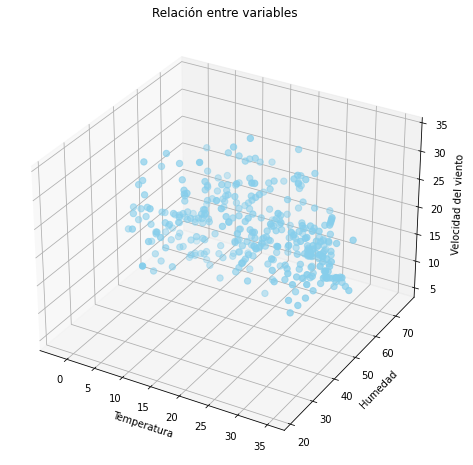

In [34]:
# https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
# La posición de los ejes es tal como se indica en el enlace superior.

# Título: Interpretar los resultados clave para Gráfica de dispersión 3D
# Url: https://support.minitab.com/es-mx/minitab/20/help-and-how-to/graphs/3d-scatterplot/interpret-the-results/key-results/

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[8,8])

ax = fig.add_subplot(111, projection='3d')
ax.scatter(train['temperature'], train['humidity'], train['windspeed'], c='skyblue', s=40)
ax.set_xlabel('Temperatura')
ax.set_ylabel('Humedad')
ax.set_zlabel('Velocidad del viento')
ax.set_title('Relación entre variables')

plt.show()


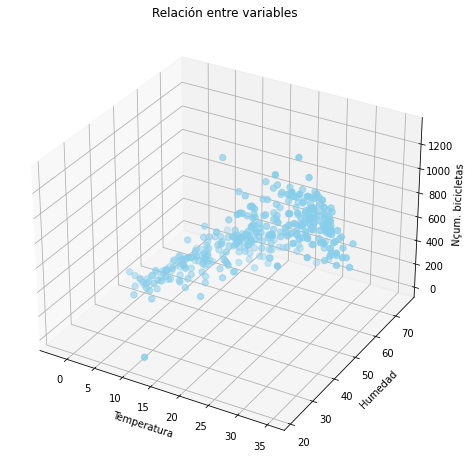

In [35]:
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train['temperature'], train['humidity'], train['count'], c='skyblue', s=40)
ax.set_xlabel('Temperatura')
ax.set_ylabel('Humedad')
ax.set_zlabel('Nçum. bicicletas')
ax.set_title('Relación entre variables')

plt.show()

### Ejer 01: 1.	En lugar de utilizar un gráfico 3D para ver la correlación de la variables, montar el código para mostrarlo por medio de una matriz de correlación, pero excluyendo la columna count. Y comparar/comentar el resultado con las features_importance (indicado más adelante) que ha deducido el modelo.

In [36]:
train
dfreduce = train.drop(['count'],axis = 1)

<AxesSubplot:>

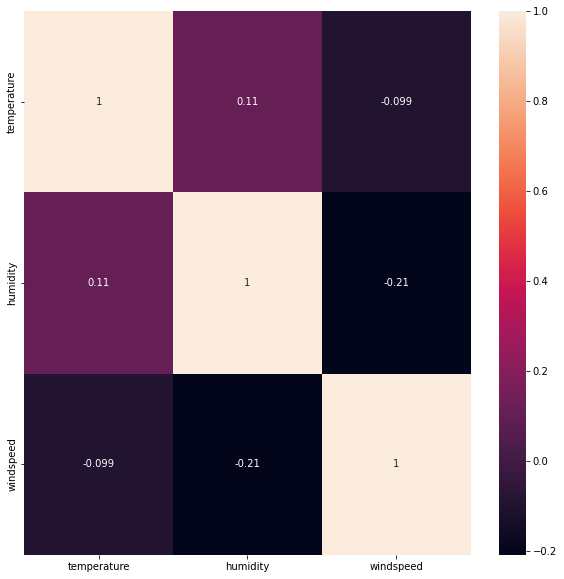

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.heatmap(dfreduce.corr(), annot=True)

***Y comparar/comentar el resultado con las features_importance (indicado más adelante) que ha deducido el modelo.***

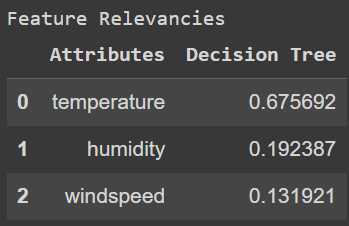

En mi opinión el features_importance nos da un buena respuesta debido a que si miramos el resultado que nos proporciona el modelo de correlación podemos verificar que el parámetro temperature es el que más correlación tiene con los otros parámetros.

#1. Parametrización

Existen diferentes parámetros que se pueden optimizar para la utilización de RandomForests,  en este caso vamos a ceñirnos a a optimizar el número de estimadores (números de árboles en el bosque) que vamos a probar con distintas potencias de 2


In [38]:
from sklearn.model_selection import TimeSeriesSplit
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
cv = TimeSeriesSplit() 

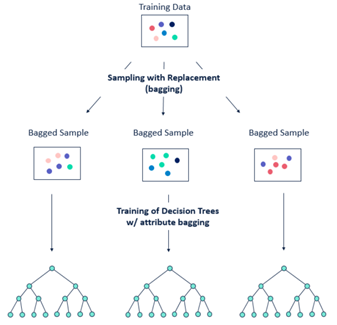

In [39]:
from sklearn.ensemble import RandomForestRegressor # Utilizamos esta librería porque es un problema de regresión,
                                                   # corresponde al modelo comentado en la D24
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np


In [40]:
# Vamos a representar en una gráfica el MAE en función del hiperparámetro n_estimator: número de árboles en el bosque
# consultar la ayuda conextual del modelo
l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

total_scores = []
for estimators in l_estimators:
   fold_accuracy = []
   # Con el parámetro n_estimator se indica el número de árboles en el bosque
   # Recuerda que el parámetro criterioon es el criterio que se va a utilizar para medir la calidad de una división, 
   #                                      es decir que las cosas que son similares deben estar juntas y las que son diferentes,
   #                                      deben separarse y distinguirse claramente unas de otras.
   #                                      Dependiendo del tipo de problema estos son los posibles valores:
   #                                             -> Clasificación: Gini, entropy
   #                                             -> Regresión: mse, mae, friedman, en la versión última (squared_error)
   # regressor =  RandomForestRegressor(n_estimators= estimators, criterion='mae', random_state=0)
   # En la nueva versión se sustituyó el error 'mae' por 'absolute_error', es equivalente
   regressor =  RandomForestRegressor(n_estimators= estimators, criterion='absolute_error', random_state=0)
   
   for train_fold, test_fold in cv.split(train):
      # División train test aleatoria
      f_train = train.loc[train_fold]
      f_test = train.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop(['count'], axis=1), 
                           y = f_train['count'])
      y_pred = regressor.predict(X = f_test.drop(['count'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['count'], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

print(total_scores)




[157.21722222222223, 150.84625, 146.61013888888888, 146.04362847222222, 148.2884982638889, 151.36220052083334, 151.58498914930556, 151.05594401041668, 151.68547146267358, 152.14295681423613]


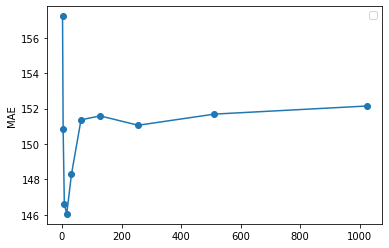

In [41]:
plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')      
    
plt.legend()
plt.show() 

In [42]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

Min Value (estimators = 16, MAE = 146.04)


# 2. Construcción y ejecución del modelo 



Una vez que hemos identificado la mejor parametrización vamos a pasar a hacer una ejecución del modelo y vamos graficar sus resultados.

Recordamos que al final del paso 1 hemos dividido en entrenamiento y test

Posteriormente, vamos a ejecutar el modelo con la mejor parametrización que hayamos obtenido anteriormente 

In [43]:
# constructor
regressor =  RandomForestRegressor(n_estimators= best_est, criterion='absolute_error', random_state=0)
# fit and predict

for train_fold, test_fold in cv.split(train):
  # División train test aleatoria
  f_train = train.loc[train_fold]
  f_test = train.loc[test_fold]
  # entrenamiento y ejecución del modelo
  regressor.fit( X = f_train.drop(['count'], axis=1), 
                        y = f_train['count'])

# MUY INTERESANTE: Entrenar sin CV y observar la diferencia del MAE, realizando el train SIN cv y CON cv
#regressor.fit( X = train.drop(['count'], axis=1), y = train['count'])
y_pred = regressor.predict(X = test.drop(['count'], axis = 1))

Calculamos el mae obtenido. Cuando se trata de una competición esta línea la ejecuta la propia competición

In [44]:
mae = mean_absolute_error(test['count'], y_pred) 
print ('MAE', mae)

MAE 247.18966302367943


Y guardamos el fichero de resultados en nuestro disco.

In [45]:
# round the result and cast to int
import numpy as np
res = np.rint(y_pred) # round
res = res.astype(int) # cast to int
# generate output
# INTERESANTE: es una forma de comparar en una hoja de cálculo lo esperado (test) y lo predicho
output = pd.DataFrame({ 'date': test.index, 'result_predict': res, 'result_test': test['count']})

from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)

files.download('result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Por último, realizamos un gráfico para visualizar cómo ha quedado nuestra predicción con respecto a la realidad que se nos indica en el dataset.

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


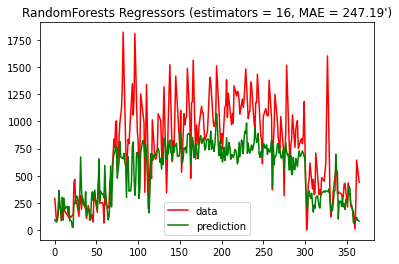

In [46]:
from sklearn.metrics import mean_absolute_error
                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(test['count'].shape[0]))
plt.plot(xx, test['count'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressors (estimators = %i, MAE = %6.2f')" % (best_est, mae))

plt.show()

In [47]:
# FEATURE RELEVANCIES
# Muy interesante porque podemos observar la relavancia de las características a la hora de entrenar el modelo.
print ('Feature Relevancies')
pd.DataFrame({'Attributes': ('temperature', 'humidity', 'windspeed') ,
              'Decision Tree': regressor.feature_importances_})

Feature Relevancies


,Attributes,Decision Tree
0,temperature,0.675692
1,humidity,0.192387
2,windspeed,0.131921


## 3. Comparativa entre diferentes modelos de árboles para el mismo problema

In [48]:
# Duda: ¿A qué tipo/técnica de árbol de los indicados en las diapos corresponden estos modelos?
# En las diapos (D22..D25) se habla de :
#      ->  Bagging(Bootstrap aggregation) 
#      ->  Random forest : Este es el ejemplo de las celdas anteriores (RandomForestRegressor)
#      ->  Boosted Trees

from sklearn.tree import DecisionTreeRegressor # Este es un modelo de un arbol individual, es decir no se utiliz la técnica de dividir el datset en subárboles
                                               # (D7) - Lo vimos en el ejemplo_3_7
from sklearn.ensemble import AdaBoostRegressor # Este pertenece a los modelos tipo Boosting (D25)
from sklearn.ensemble import GradientBoostingRegressor # Este pertenece a los modelos tipo Boosting (D25)
from sklearn.ensemble import BaggingClassifier # Este pertenece a los modelos tipo Bagging (D23)

# Fit regression model
regressors = []
regressors.append(DecisionTreeRegressor(max_depth=6, criterion='absolute_error'))

# http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html#
regressors.append(AdaBoostRegressor(DecisionTreeRegressor(max_depth=6, criterion='absolute_error'), n_estimators=128, random_state=0))

# http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py                         
regressors.append(GradientBoostingRegressor(n_estimators=50, learning_rate=0.25, random_state=0, loss='squared_error'))

# No utilizamos el algoritmo para los árboles tipo Bagging porque el data set de ejemplo es un problema de tipo de regresión con valores continuos
# y da error al ejecutarse
#
# En este otro artículo se muestra un ejemplo con un problema de clasificación: 
# https://vitalflux.com/bagging-classifier-python-code-example/
#
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
# regressors.append(BaggingClassifier(n_estimators=10, random_state=0))


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


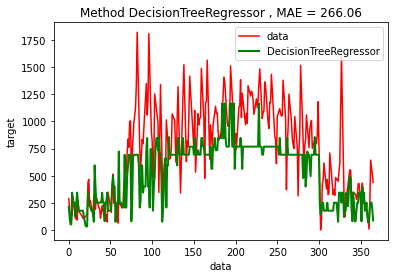

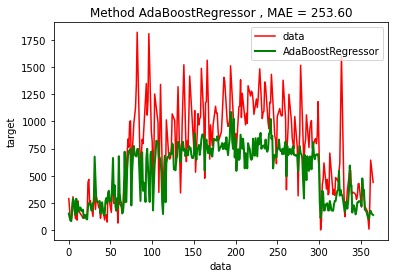

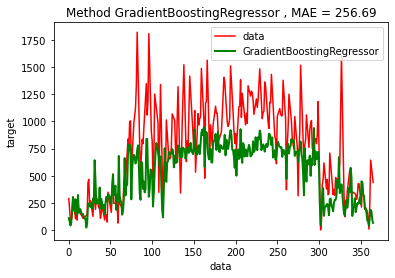

In [49]:
# En la variable(array) xx guarda los valores del 0 al 365. Que corresponden con el número de muestras del conjunto de datos de test
xx = np.stack(i for i in range(len(test['count'])))
# DT -> DecisionTreeRegressor
# AB -> AdaBoostRegressor
# GB -> GradientBoostingRegressor

#regr_names = ["DT", "AB", "GB"]
regr_names = ["DecisionTreeRegressor", "AdaBoostRegressor", "GradientBoostingRegressor"]

results = pd.DataFrame()
results['real'] = test['count']

for i, r in enumerate(regressors):
    r.fit( X = train.drop(['count'], axis=1), y = train['count'])
    y = r.predict(X = test.drop(['count'], axis = 1))
    results[regr_names[i]] = y
    mae = mean_absolute_error(test['count'],y)
    
    # Plot the results
    plt.figure()
    plt.plot(xx, test['count'], c='r', label='data')
    plt.plot(xx, y, c="g", label=regr_names[i], linewidth=2)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Method %s , MAE = %6.2f" % (regr_names[i], mae ))
    plt.axis('tight')
    plt.legend()
    plt.show()

In [50]:
#from google.colab import files

#with open('results_comparativemodels.xlsx', 'wb') as f:
  #results.to_excel(f,  index = True)

#files.download('results_comparativemodels.xlsx')

### Ejer 02: Aplicando la técnica de Cross Validation, realizar la comparativa entre los diferentes modelos.

####Explicación del Ejercicio 2
La diferencia entre el 2.1 y 2.2 es que en el primero, tras haber separado dos grupos, uno para entrenar(f_train) y otro para testear(f_test). En el entrenamiento vamos a utilizar el f_train con la función fit. La diferencia que tiene este apartado con el siguiente es que haremos la predicción con el f_test sacado anteriormente y vamos a evaluar el modelo con el MAE (Error absoluto medio). Para finalizar, como puedes comprobar el MAE es mucho menos a que si utilizamos el train. Que lo explicaré más adelante. Como último detalle voy a coger los resultados del 2.1 y volcarlos en el exel, debido a que este apartado creo que es el correcto.

####2.1

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


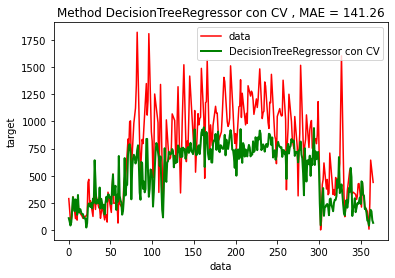

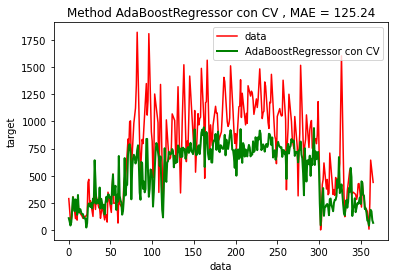

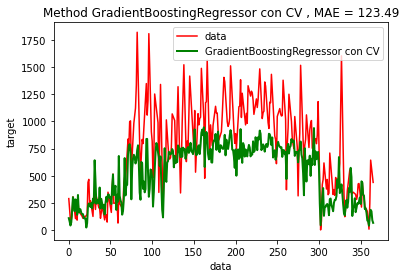

In [51]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

xx = np.stack(i for i in range(len(test['count'])))

regr_names = ["DecisionTreeRegressor con CV", "AdaBoostRegressor con CV", "GradientBoostingRegressor con CV"]
 
results_cv = pd.DataFrame()

cv = TimeSeriesSplit(n_splits = 5) # Debemos utilizar este método porque trabajaremos con series temporales.

for i, r in enumerate(regressors):
  # verificar cada uno de los modelos con validación cruzada.
  for train_fold, test_fold in cv.split(train):
    
    # División train test aleatoria
    f_train = train.loc[train_fold]
    f_test = train.loc[test_fold]
    respuestas = np.array(f_test['count'], dtype = 'float64')
    results_cv['real'] = respuestas

    # entrenamiento y ejecución del modelo
    r.fit( X = f_train.drop(['count'], axis=1), y = f_train['count'])
    y_pred = r.predict(X = f_test.drop(['count'], axis = 1))
    results_cv[regr_names[i]] = y_pred

    # evaluación del modelo
    mae = mean_absolute_error(f_test['count'], y_pred)
    
  # Plot the results
  plt.figure()
  plt.plot(xx, test['count'], c='r', label='data')
  plt.plot(xx, y, c="g", label=regr_names[i], linewidth=2)
  plt.xlabel("data")
  plt.ylabel("target")
  plt.title("Method %s , MAE = %6.2f" % (regr_names[i], mae ))
  plt.axis('tight')
  plt.legend()
  plt.show()

Ahora voy a comenzar la explicación de la segunada parte de apartado, tras haber separado dos grupos, uno para entrenar(f_train) y otro para testear(f_test). En el entrenamiento vamos a utilizar el f_train con la función fit. La diferencia que hay es que haremos la predicción con el test la cual es muy desconcertante pero comprobando ejercicios anteriores esta es la manera que nos mostran. Pero no entiendo como este puede dar menos que el anterior si se entrena con los mismos datos pero se testean con unos diferentes  y para finalizar vamos a evaluar el modelo con el MAE (Error absoluto medio). 

####2.2

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


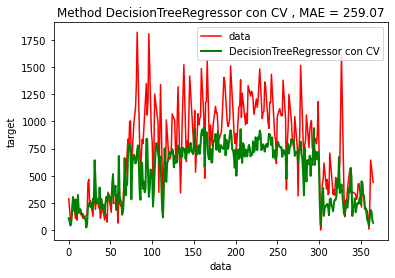

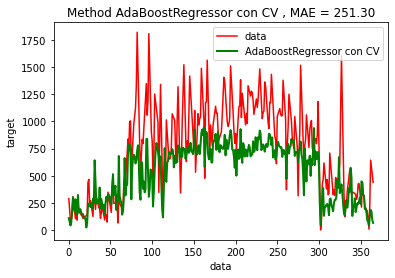

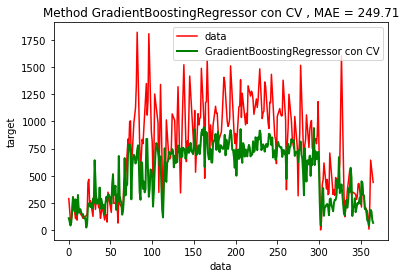

In [52]:
xx = np.stack(i for i in range(len(test['count'])))

regr_names = ["DecisionTreeRegressor con CV", "AdaBoostRegressor con CV", "GradientBoostingRegressor con CV"]

cv = TimeSeriesSplit(n_splits = 5) # Debemos utilizar este método porque trabajaremos con series temporales.

for i, r in enumerate(regressors):
  # verificar cada uno de los modelos con validación cruzada.
  for train_fold, test_fold in cv.split(train):
    
    # División train test aleatoria
    f_train = train.loc[train_fold]
    f_test = train.loc[test_fold]

    # entrenamiento y ejecución del modelo
    r.fit( X = f_train.drop(['count'], axis=1), y = f_train['count'])
    y_pred = r.predict(X = test.drop(['count'], axis = 1))

    # evaluación del modelo
    mae = mean_absolute_error(test['count'], y_pred)
    
  # Plot the results
  plt.figure()
  plt.plot(xx, test['count'], c='r', label='data')
  plt.plot(xx, y, c="g", label=regr_names[i], linewidth=2)
  plt.xlabel("data")
  plt.ylabel("target")
  plt.title("Method %s , MAE = %6.2f" % (regr_names[i], mae ))
  plt.axis('tight')
  plt.legend()
  plt.show()

### Ejer 03: Obtener en un único fichero Excel los resultados obtenidos en todos los modelos utilizados.

In [53]:
from google.colab import files

df_vacio = {}
df_comparar = pd.DataFrame(df_vacio)
df_comparar.to_excel('results_comparativemodels.xlsx', index = False)

escribir = pd.ExcelWriter('results_comparativemodels.xlsx')

results.to_excel(escribir, 'Modelos sin Cross Validation',  index = True)
results_cv.to_excel(escribir, 'Modelos con Cross Validation',  index = True)

escribir.save()
escribir.close()

files.download('results_comparativemodels.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Ejer 04: Para analizar los resultados obtenidos en este problema, ¿tendría sentido utilizar la matriz de confusión?. Explicarlo

No tiene ningún sentido utilizar la matriz de confución para analizar los resultados ya que esta solo se utiliza únicamente cuando hay problemas de clasificasión, es decir, el resultado es limitado.

###Link del GitHub
https://github.com/Ruben11040/Proyectos_Colab/tree/main/Random_Forests_para_Regresi%C3%B3n